# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as** Recurrent layers** or **LSTMs** you will **also use Convolutional layers** to improve the model's performance.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is **no need** to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [13]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter= ',')

        # Skip the first line
        next(reader)

        # Append col and sunspot number to lists
        for col in reader:
          times.append((col[0]))
          temperatures.append(float(col[1]))

        ### END CODE HERE
            
    return times, temperatures


The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

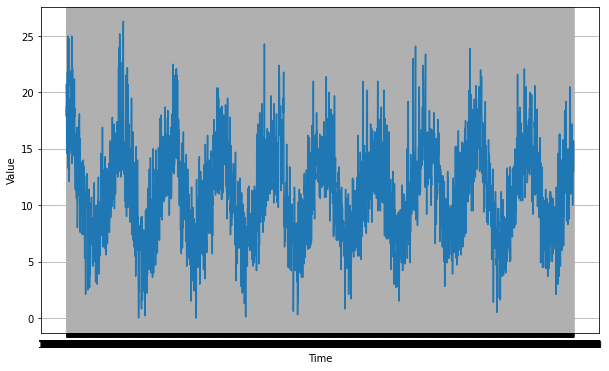

In [14]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Expected Output:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [15]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [16]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## **Defining the model architecture**

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [26]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu', 
                               input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=  True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
        
    ]) 
    
    ### END CODE HERE

    return model

In [27]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [28]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss= tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [29]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
10/10 [==============================] - 7s 317ms/step - loss: 10.2264 - mae: 10.7254 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 3s 312ms/step - loss: 10.0077 - mae: 10.5064 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 3s 314ms/step - loss: 9.6683 - mae: 10.1668 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 3s 314ms/step - loss: 9.2799 - mae: 9.7785 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 4s 323ms/step - loss: 8.8923 - mae: 9.3906 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 5s 372ms/step - loss: 8.5265 - mae: 9.0246 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 4s 324ms/step - loss: 8.1386 - mae: 8.6365 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 4s 316ms/step - loss: 7.7158 - mae: 8.2119 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 4s 320ms/step - loss: 7.2494 - mae: 7.

(0.0001, 10.0, 0.0, 10.0)

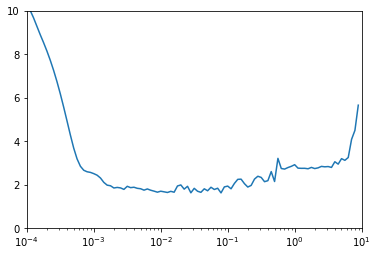

In [30]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## **Compiling the model**
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [31]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer= tf.keras.optimizers.SGD(learning_rate = 1e-2 , momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [32]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 8s 321ms/step - loss: 7.7487 - mae: 8.2441
Epoch 2/50
10/10 [==============================] - 4s 316ms/step - loss: 3.2250 - mae: 3.7000
Epoch 3/50
10/10 [==============================] - 4s 316ms/step - loss: 2.8084 - mae: 3.2759
Epoch 4/50
10/10 [==============================] - 3s 314ms/step - loss: 2.7578 - mae: 3.2267
Epoch 5/50
10/10 [==============================] - 4s 316ms/step - loss: 2.6348 - mae: 3.1001
Epoch 6/50
10/10 [==============================] - 4s 321ms/step - loss: 2.5828 - mae: 3.0471
Epoch 7/50
10/10 [==============================] - 4s 319ms/step - loss: 2.4879 - mae: 2.9512
Epoch 8/50
10/10 [==============================] - 4s 319ms/step - loss: 2.3224 - mae: 2.7816
Epoch 9/50
10/10 [==============================] - 4s 324ms/step - loss: 2.1525 - mae: 2.6076
Epoch 10/50
10/10 [==============================] - 4s 321ms/step - loss: 2.3991 - mae: 2.8635
Epoch 11/50
10/10 [==============================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [33]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

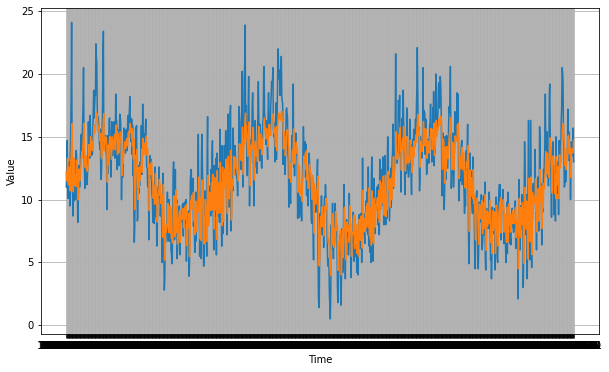

In [35]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [36]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.39, mae: 1.81 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in a HDF5 file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [37]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/saved_model.pb
saved_model/my_model/keras_metadata.pb
saved_model/my_model/assets/
saved_model/my_model/variables/
saved_model/my_model/variables/variables.index
saved_model/my_model/variables/variables.data-00000-of-00001


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**